## <제너레이터와 모델 생성>

In [1]:
from collections import Counter
import cv2
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle, Circle
from mtcnn.mtcnn import MTCNN
from tqdm import tqdm
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input

Using TensorFlow backend.


In [ ]:
# FACE_DEFAULT_SHAPE = (128, 96)
FACE_DEFAULT_SHAPE = (224, 224)
detector = MTCNN()

train_df = pd.read_csv('./labels/train.pre.small.csv')
valid_df = pd.read_csv('./labels/valid.pre.small.csv')
test_df = pd.read_csv('./labels/test.small.csv')


train_vec_128 = np.load('outputs/train_vec.small.128.npy')
valid_vec_128 = np.load('outputs/valid_vec.small.128.npy')

print(train_vec_128.shape, valid_vec_128.shape)

## <전처리 함수 선언>

In [3]:
# 전처리 함수
def preprocess(detector, img, face_shape, file=None):
    # 얼굴 크롭
    faces = detector.detect_faces(img)
    if len(faces) != 1 :  # detect된 얼굴이 1개가 아닌 경우, 해당 데이터는 처리하지 않는다.
        return None
    
    x, y, w, h = faces[0]['box']
    
    if w < 10 or h < 10:  # detect 된 얼굴 pixel이 너무 작으면, 크롭하지 않는다.
        print('face does not exists', faces[0]['box'], file)
    else:
        # detect된 좌표를 보정한다.
        if x < 0 :
            w += x
            x = 0
        if y < 0 :
            h += y
            y = 0    
        
        # detect 패치의 중심좌표를 기준으로 정사각형으로 크롭한다.
        center_x = x + int(w/2)
        center_y = y + int(h/2)
        margin = max(w, h)
        x = center_x - int(margin/2)
        y = center_y - int(margin/2)
        if x < 0 :
            x = 0
        if y < 0 :
            y = 0  

        img = img[y:y+margin, x:x+margin, :]

    (h, w, _) = img.shape
    if h > w:
        # target shape에 행을 기준으로 맞추기
        new_w = int(w/h*face_shape[0])
        new_h = int(face_shape[0])
    else:
        # target shape에 열을 기준으로 맞추기
        new_w = int(face_shape[1])
        new_h = int(h/w*face_shape[1])
        
    try:
        img = cv2.resize(img, (new_w, new_h))    
    except Exception as e:
        msg = 'None ==>' +  file +' '+ str(img.shape) + ' ' + str(new_w) + ' ' + str(new_h) + ' ' + str(faces[0])
        print(msg)
        return None
    
    new_img = np.zeros(face_shape + (3, ))
    (h, w, _) = new_img.shape
    if face_shape[0] == new_h:
        new_img[:, int(w/2-new_w/2):int(w/2+new_w/2), :] = img
    else:    
        new_img[int(h/2-new_h/2):int(h/2+new_h/2):, :, :] = img
    return new_img

In [5]:
model = load_model('outputs/siamese.densenet169.h5', compile=False)
inp = model.input[0]
base_model = model.layers[3]
infer_model = Model(inp, base_model(inp))
infer_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
anchor (InputLayer)          [(None, 224, 224, 3)]     0         
_________________________________________________________________
model (Model)                (None, 128)               13561024  
Total params: 13,561,024
Trainable params: 13,402,624
Non-trainable params: 158,400
_________________________________________________________________


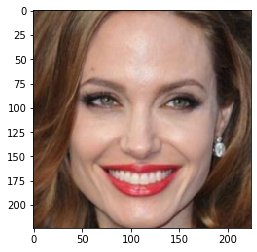

(1, 128)

In [9]:
def infer(model, detector, img_path, input_shape, is_debug=True):
    img = image.load_img(img_path)
    img = image.img_to_array(img)
    new_img = preprocess(detector, img, input_shape)
    if type(new_img) == type(None):
        return None
    
    if is_debug:
        plt.figure()
        plt.imshow(new_img.astype('uint8'))
        plt.show()
        
    x = np.expand_dims(new_img, axis=0)
    x = preprocess_input(x)
    pred = model.predict(x)
    return pred

FACE_DEFAULT_SHAPE = (224, 224)
# img_path = 'test_imgs/mark_z.JPG'
# img_path = '../data/img_align_celeba/188986.jpg' # 윤아 - test
# img_path = '../data/img_align_celeba/200535.jpg' # 윤아 - train
img_path = '../../data/img_celeba/187853.jpg' # 안젤리나 졸리 - test label 5876
# img_path = '../data/img_celeba/114190.jpg' # 

pred_128 = infer(infer_model, detector, img_path, FACE_DEFAULT_SHAPE)    
pred_128.shape

In [10]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
# res = cosine_similarity(valid_vec_128, pred_128)
# res2 = euclidean_distances(valid_vec_128, pred_128)
# res3 = -np.matmul(valid_vec_128, pred_128.T)
res = cosine_similarity(train_vec_128, pred_128)
res2 = euclidean_distances(train_vec_128, pred_128)
res3 = -np.matmul(train_vec_128, pred_128.T)

np.max(res)

0.9840361883306837

In [11]:
from collections import Counter

# 임계값 이상인 데이터의 라벨별 카운트
idx, _ = np.where(res > 0.80)
cnt_dict = Counter(train_df.iloc[idx]['label'])
cnt_dict_sorted = sorted(cnt_dict.items(), key=(lambda x:x[1]), reverse=True)
cnt_dict_sorted[:5]

[(4220, 24), (5876, 24), (8072, 24), (3117, 23), (4860, 23)]

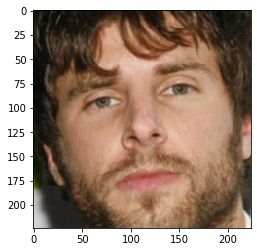

In [22]:
sample_img_name = train_df[train_df['label']==cnt_dict_sorted[0][0]]['image'].values[0]
img = image.load_img('../../data/img_celeba_preprocess/' + sample_img_name)
x = image.img_to_array(img)
plt.imshow(x.astype('uint8'))

In [15]:
# 라벨별 유사도의 평균을 구하고 제일 높은 라벨 선택
train_df['sim'] = res
df  = train_df.groupby(['label'])['sim'].mean().reset_index()
df = df.sort_values(by=['sim'], ascending=False)
df = df.reset_index()
print(df.shape)
# df[df['label']==5876]
df.head(5)

(50, 3)


,index,label,sim
0,4,1951,0.948419
1,28,6920,0.947921
2,40,8715,0.947431
3,11,3398,0.947068
4,48,10062,0.946683


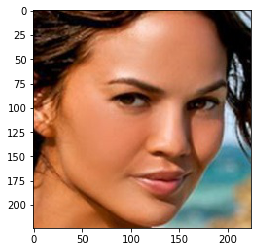

In [20]:
sample_img_name = train_df[train_df['label']==df['label'].values[0]]['image'].values[0]
img = image.load_img('../../data/img_celeba_preprocess/' + sample_img_name)
x = image.img_to_array(img)
plt.imshow(x.astype('uint8'))

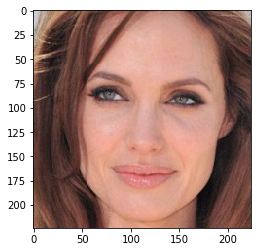

In [24]:
# 그냥 유사도가 제일 높은 이미지
sorted_similar = np.argsort(res*-1, axis=0)
sorted_similar2 = np.argsort(res2, axis=0)
sorted_similar3 = np.argsort(res3, axis=0)

img = image.load_img('../../data/img_celeba_preprocess/' + train_df.iloc[sorted_similar[0][0]][0])
# img = image.load_img('../data/img_align_celeba/' + train_df.iloc[sorted_similar2[0][0]][0])
x = image.img_to_array(img)
plt.imshow(x.astype('uint8'))

082098.jpg 129644.jpg 0.9833852716245617 4478 4478


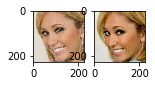

093017.jpg 147461.jpg 0.9814615584651211 1951 1951


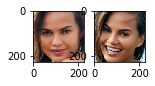

095247.jpg 143888.jpg 0.9857571422175386 7443 7443


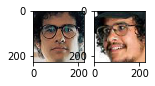

099316.jpg 115830.jpg 0.9555651492326174 2095 2095


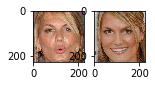

099583.jpg 011813.jpg 0.9723656282178978 9039 9039


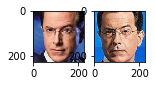

106077.jpg 137324.jpg 0.9990062101590838 9177 9177


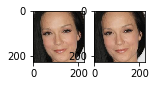

109956.jpg 137324.jpg 0.9920679175443053 9177 9177


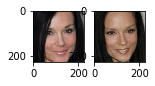

113558.jpg 149069.jpg 0.9965850515546775 5986 5986


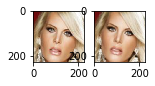

171747.jpg 178832.jpg 0.9508832233747422 1927 1927


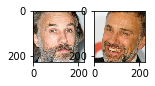

192543.jpg 200439.jpg 0.9797652856247556 6920 6920


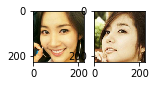

194070.jpg 201235.jpg 0.9822757171768625 8715 8715


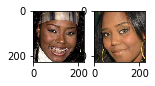

194180.jpg 200439.jpg 0.9890125195167416 6920 6920


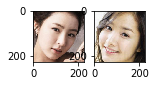

194423.jpg 200439.jpg 0.9783069760041299 6920 6920


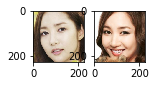

194537.jpg 198860.jpg 0.9715078946981198 8963 8963


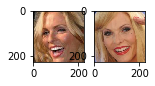

195351.jpg 198860.jpg 0.9633319641624393 8963 8963


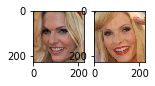

197569.jpg 201235.jpg 0.9884664704852775 8715 8715


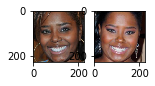

In [31]:
import glob
import tqdm
import os
from collections import Counter

data_df = pd.read_csv('./labels/identity_CelebA.txt', sep=" ", header=None)
data_df.columns = ["image", "label"]
thresh=0.5

def get_label(data_df, img_path):
    img_name = os.path.basename(img_path)
    _df = data_df[data_df['image']==img_name]
    if _df.shape[0] == 0:
        return None
    return _df['label'].values[0]
    
report_list = []
for query_img in sorted(valid_df['image'].values):
    query_img_path = os.path.join('../../data/img_celeba', query_img)
    pred_128 = infer(infer_model, detector, query_img_path, FACE_DEFAULT_SHAPE, is_debug=False)    
    if type(pred_128) == type(None):
        continue
    res = cosine_similarity(train_vec_128, pred_128)
    sorted_similar = np.argsort(res*-1, axis=0)
    if np.max(res) < thresh: 
        continue
    
#     idx, _ = np.where(res > thresh)
#     cnt_dict = Counter(train_df.iloc[idx]['label'])  # 라벨카운트.
#     cnt_dict_sorted = sorted(cnt_dict.items(), key=(lambda x:x[1]), reverse=True)
#     sim_label = cnt_dict_sorted[0][0]
    
    train_df['sim'] = res
    df  = train_df.groupby(['label'])['sim'].mean().reset_index()
    df = df.sort_values(by=['sim'], ascending=False)
    df = df.reset_index()
    sim_label = df['label'].values[0]
    
    sim_list = list(res[train_df[train_df['label']==sim_label].index].reshape(-1))
    sim_img_list = train_df[train_df['label']==sim_label]['image'].values.tolist()
    
    query_img_label = get_label(data_df, query_img)
    
    max_sim = 0
    max_sim_img = ''
    for _sim, _sim_img in zip(sim_list, sim_img_list):
        report = {}
        report['query'] = query_img
        report['sim'] = _sim_img
        report['query_label'] = query_img_label
        report['sim_label'] = sim_label
        report['sim_value'] = _sim
        report_list.append(report)
        if _sim > max_sim:
            max_sim = _sim
            max_sim_img = _sim_img
            
    if query_img_label != sim_label:
        continue
        
    sample_sim_img_path = os.path.join('../../data/img_celeba', max_sim_img)
    print(query_img, sim_img_list[0], max_sim, query_img_label, sim_label)
    fig = plt.figure(figsize=(2,2))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    
    img = image.load_img(query_img_path)
    img = image.img_to_array(img)
    img = preprocess(detector, img, FACE_DEFAULT_SHAPE)
    if type(img)!=type(None):
        ax1.imshow(img.astype('uint8'))
    
    img = image.load_img(sample_sim_img_path)
    img = image.img_to_array(img)
    img = preprocess(detector, img, FACE_DEFAULT_SHAPE)
    if type(img)!=type(None):
        ax2.imshow(img.astype('uint8'))
    plt.show()    
    
report_df = pd.DataFrame(report_list)

In [32]:
report_df.to_csv('outputs/report.train.valid.small.csv', index=False)

In [33]:
print(report_df.shape)
print(report_df[report_df['query_label']==report_df['sim_label']].shape)

(2899, 5)
(339, 5)
